<a href="https://colab.research.google.com/github/Vaggelis-Arg/Amazon-Ecommerce-Analysis/blob/main/Amazon_Ecommerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining (2024-2025)

### Team Information

#### Team member #1: [**Vaggelis-Arg**](https://github.com/Vaggelis-Arg)
* Name: Evangelos Argyropoulos
* ID: sdi2200010
* Email: sdi2200010@di.uoa.gr
---
#### Team member #2: [**chrisvl11**](https://github.com/chrisvl11)
* Name: Christos Vladikas
* ID: sdi2200020
* Email: sdi2200020@di.uoa.gr
---
#### Team member #3: [**tonykalantzis**](https://github.com/tonykalantzis)
* Name: Antonios Panagiotis Kalatzis
* ID: sdi2100046
* Email: sdi2100046@di.uoa.gr
---

## Set up of the notebook

### Downloads

In [ ]:
!pip install nltk transformers torch contractions matplotlib seaborn wordcloud hf_xet scikit-learn
!pip install -U datasets

### Remove any leftover datasets from previous runs

In [ ]:
!rm -f *.csv

### Imports

In [ ]:
import nltk
nltk.download(['punkt', 'stopwords', 'vader_lexicon', 'wordnet','omw-1.4'])
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
import pandas as pd
import re
import string
import contractions
from nltk.corpus import stopwords
from datasets import load_dataset
from matplotlib.gridspec import GridSpec
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.sparse import hstack
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Part 1 - Pre-processing

### Task 1: Data Exploration and Feature Engineering

#### Dataset Preparation

We used the `datasets` library from Hugging Face to stream and extract reviews and metadata for selected Amazon product categories.

The dataset includes product reviews, ratings, and associated metadata. After loading, the data was saved as CSV files (`*_reviews_raw.csv` and `*_metadata_raw.csv`) to simplify further processing.

We ensure the CSVs contain essential fields like `rating`, `text`, `parent_asin`, and product details for later analysis.



In [ ]:
# Configs: (category_name, review_config, meta_config)
datasets_info = [
    #("Books", "raw_review_Books", "raw_meta_Books"),
    ("All_Beauty", "raw_review_All_Beauty", "raw_meta_All_Beauty"),
    #("Electronics", "raw_review_Electronics", "raw_meta_Electronics"),
    #("Movies_and_TV", "raw_review_Movies_and_TV", "raw_meta_Movies_and_TV"),
    #("Sports_and_Outdoors", "raw_review_Sports_and_Outdoors", "raw_meta_Sports_and_Outdoors"),
]

# Select correct columns
review_columns = [
    "rating", "title", "text", "parent_asin", "user_id", "timestamp",
    "helpful_vote", "verified_purchase"
]
meta_columns = [
    "parent_asin", "main_category", "title", "average_rating", "rating_number",
    "description", "price", "categories", "bought_together", "store"
]

for category, review_config, metadata_config in datasets_info:
    print(f"Loading: {category}")

    # Load streaming datasets with limited columns
    reviews_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        review_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(review_columns)

    metadata_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        metadata_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(meta_columns)

    # Convert to pandas and save
    reviews_df = pd.DataFrame(reviews_iter.take(200_000))
    metadata_df = pd.DataFrame(metadata_iter.take(200_000))

    reviews_df.to_csv(f"{category}_reviews.csv", index=False)
    metadata_df.to_csv(f"{category}_metadata.csv", index=False)

    print(f"Saved selected columns for {category}")


Loading: All_Beauty
Saved selected columns for All_Beauty


#### Text Preprocessing

Text fields like `title` and `review text` were cleaned using a custom preprocessing function that includes:

- Lowercasing
- URL, mention, hashtag, and email removal
- Contraction expansion (`don't` → `do not`)
- Emoticon normalization (e.g., `:)` → `happy`)
- Removal of punctuation, numbers, and excessive character repetitions
- Lemmatization (reducing words to their base or dictionary form, e.g., running → run)

These cleaned fields (`cleaned_title`, `cleaned_text`) are used for visualizations and later analysis tasks.


In [ ]:
# Emoticon dictionary for replacements
nltk.download(['punkt', 'stopwords', 'vader_lexicon', 'wordnet','omw-1.4', 'punkt_tab'])
emoticons = {
    ":)": "happy", ":D": "very happy", ":-)": "happy", "(:": "happy",
    ";)": "winking", ";-)": "winking", "(:": "happy", "^^": "happy",
    ":(": "sad", ":-(": "sad", "):": "sad",
    ":o": "surprised", ":-o": "surprised", ":O": "shocked",
    ":'(": "crying", ":-'(": "crying",
    ":P": "playful", ":-P": "playful", ";P": "cheeky", ";-P": "cheeky",
    "<3": "love", "</3": "heartbroken"
}
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def normalize_price(price, min_price, max_price):
    return (price - min_price) / (max_price - min_price) if max_price != min_price else 0

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", 'link', text)  # replace URLs
    text = re.sub(r"\@\w+|\#\w+", 'tag', text)  # replace mentions and hashtags
    text = re.sub(r"\S+@\S+", 'mail', text)  # replace emails
    text = re.sub(r'\d+', 'number', text) # replace numbers
    text = contractions.fix(text)  # expand contractions

    # Replace emoticons
    for emoticon, word in emoticons.items():
        text = text.replace(emoticon, word)

    text = re.sub(r"[" + string.punctuation + "]", '', text)  # remove punctuation
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  # reduce 3+ char repeats to 2

    text = text.strip()

    # Tokenize and Lemmatize

    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    text = ' '.join(tokens)
    return text

# Load and clean each dataset
for category, *_ in datasets_info:
    print(f"Processing: {category}")
    reviews = pd.read_csv(f"{category}_reviews.csv")
    metadata = pd.read_csv(f"{category}_metadata.csv")

    reviews = reviews.dropna(subset=["rating", "text", "parent_asin"])
    reviews["cleaned_title"] = reviews["title"].apply(preprocess_text)
    reviews["cleaned_text"] = reviews["text"].apply(preprocess_text)
    reviews["timestamp"] = pd.to_datetime(reviews["timestamp"], unit="ms")

    metadata["cleaned_title_meta"] = metadata["title"].apply(preprocess_text)
    metadata["cleaned_description"] = metadata["description"].apply(preprocess_text)

    df = pd.merge(reviews, metadata, on="parent_asin", how="left", suffixes=("", "_meta"))

    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')

        # Remove any rows where price is NaN
        df = df.dropna(subset=['price'])

        min_price = df['price'].min()
        max_price = df['price'].max()
        #df['normalized_price'] = df['price'].apply(lambda x: normalize_price(x, min_price, max_price))

    df.to_csv(f"{category}_cleaned.csv", index=False)
    print(f"Saved cleaned data to {category}_cleaned.csv")

print(reviews.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Processing: All_Beauty
Saved cleaned data to All_Beauty_cleaned.csv
   rating                                      title  \
0     5.0  Such a lovely scent but not overpowering.   
1     4.0     Works great but smells a little weird.   
2     5.0                                       Yes!   
3     1.0                          Synthetic feeling   
4     5.0                                         A+   

                                                text parent_asin  \
0  This spray is really nice. It smells really go...  B00YQ6X8EO   
1  This product does what I need it to do, I just...  B081TJ8YS3   
2                          Smells good, feels great!  B097R46CSY   
3                                     Felt synthetic  B09JS339BZ   
4                                            Love it  B08BZ63GMJ   

                        user_id               timestamp  helpful_vote  \
0  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-05 14:08:48.923             0   
1  AGKHLEW2SOWHNMFQIJGBECAF7INQ 2020-05-

#### Ratings and Reviews

We performed exploratory data analysis on the cleaned dataset, including:

##### 1. Rating Distribution

We plotted a histogram to show how product ratings are distributed across all reviews in each category.

##### 2. Low-Rated Popular Products – Word Cloud

We identified products with an average rating below 3 and a sufficient number of reviews, then generated a word cloud from their review texts to highlight frequently used negative terms.

##### 3. Rating Trends Over Time

We computed the average rating per month and plotted a line chart to observe how customer sentiment evolves over time. This helps detect seasonality or significant shifts in perception.

##### 4. Top 5 Best-Selling Products

We listed the five most-reviewed products in each category, including:
- Title
- ASIN
- Store (if available)
- Average rating
- Total number of reviews

Visualizing: All_Beauty


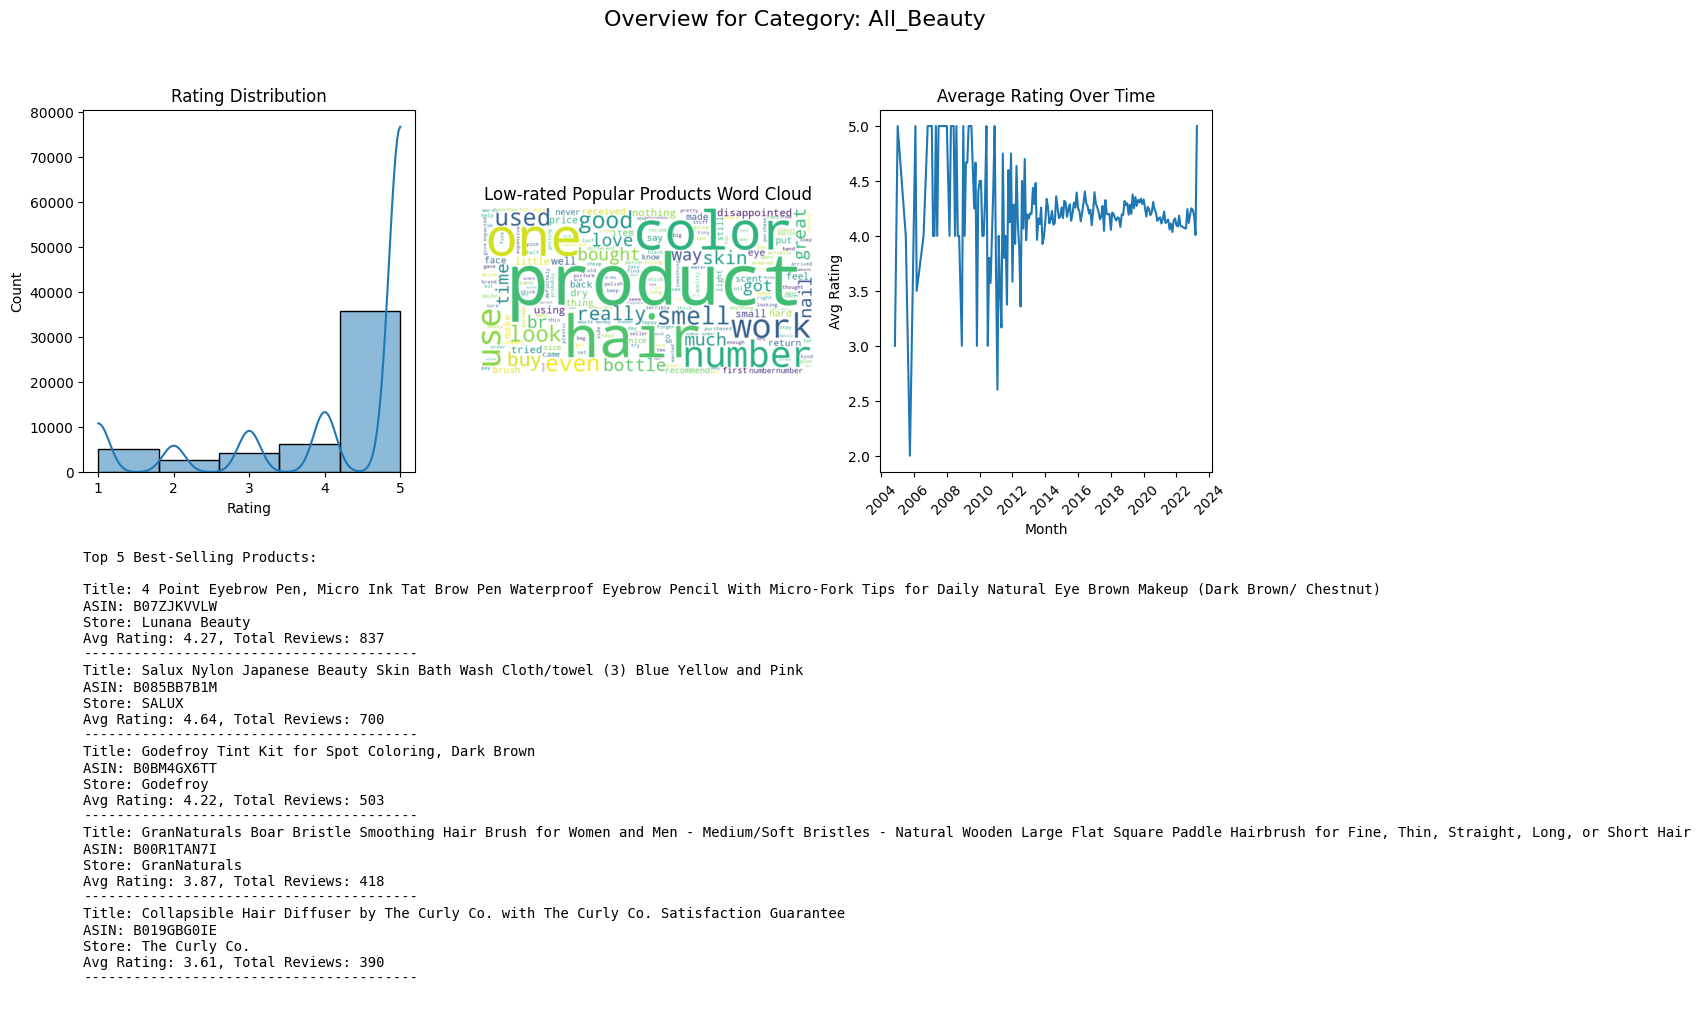

In [ ]:
for category, *_ in datasets_info:
    print(f"Visualizing: {category}")
    df = pd.read_csv(f"{category}_cleaned.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["month"] = df["timestamp"].dt.to_period("M").dt.to_timestamp()

    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df = df.dropna(subset=["rating"])

    stats = df.groupby("parent_asin").agg(
        avg_rating=("rating", "mean"),
		count=("rating", "count")
	).reset_index()

    bad_asins = stats[
    	(stats["count"] >= 0) & (stats["avg_rating"] < 3)
	]["parent_asin"]

    bad_text = " ".join(df[df["parent_asin"].isin(bad_asins)]["cleaned_text"].dropna())
    wordcloud = None
    if bad_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(bad_text)

    # Prepare trend data
    trend = df.groupby("month")["rating"].mean().reset_index()

    # Prepare top products text
    top5 = df["parent_asin"].value_counts().head(5).index
    top_products_info = ""
    for asin in top5:
        item = df[df["parent_asin"] == asin].iloc[0]
        avg_rating = df[df["parent_asin"] == asin]["rating"].mean()
        total_reviews = len(df[df["parent_asin"] == asin])
        top_products_info += (
            f"Title: {item.get('title_meta', 'N/A')}\n"
            f"ASIN: {asin}\n"
            f"Store: {item.get('store', 'Unknown')}\n"
            f"Avg Rating: {avg_rating:.2f}, Total Reviews: {total_reviews}\n"
            f"{'-'*40}\n"
        )

    # Create subplots
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f"Overview for Category: {category}", fontsize=16, y=1.02)
    gs = GridSpec(2, 3, figure=fig)

    # Histogram
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df["rating"], bins=5, kde=True, ax=ax1)
    ax1.set_title("Rating Distribution")
    ax1.set_xlabel("Rating")
    ax1.set_ylabel("Count")

    # Word Cloud
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Low-rated Popular Products Word Cloud")
    if wordcloud:
        ax2.imshow(wordcloud, interpolation="bilinear")
        ax2.axis("off")
    else:
        ax2.text(0.5, 0.5, "No data for word cloud", ha='center', va='center', fontsize=12)
        ax2.axis("off")

    # Trend Line
    ax3 = fig.add_subplot(gs[0, 2])
    sns.lineplot(data=trend, x="month", y="rating", ax=ax3)
    ax3.set_title("Average Rating Over Time")
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Avg Rating")
    ax3.tick_params(axis='x', rotation=45)

    # Text Box for Top Products
    ax4 = fig.add_subplot(gs[1, :])
    ax4.axis("off")
    ax4.text(0, 1, f"Top 5 Best-Selling Products:\n\n{top_products_info}", ha='left', va='top', fontsize=10, family='monospace')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


### Task 2: Feature Engineering with Sentiment Scores and Ratings

#### SentimentScoreWithRating Class

This class combines the **text sentiment** of a review with its **numeric rating (1–5)** to generate a more informative sentiment score.

---

#### 1. Sentiment Extraction

- Uses either **VADER** or a **Hugging Face model** (`DistilBERT`, `RoBERTa`, or `BERT`)
- Converts review text to a sentiment score in the range:

$$
\text{sentiment\_score} \in [-1, 1]
$$

---

#### 2. Weighted Sentiment + Rating

To balance sentiment from text and numeric rating:

$$
\text{final\_score} = w_1 \cdot \text{sentiment\_score} + w_2 \cdot \text{normalized\_rating}
$$

where:

$$
\text{normalized\_rating} = \frac{\text{rating} - 1}{4}
$$

Default weights: \( w_1 = 0.5 \), \( w_2 = 0.5 \)

---

#### 3. Rating-Adjusted Sentiment

Boost or reduce sentiment depending on how strong the rating is:

- Add adjustment (e.g. +0.2) if rating is 4 or 5  
- Subtract adjustment (e.g. -0.2) if rating is 1 or 2

This ensures the final score reflects both tone and user satisfaction.

---

In [ ]:
class SentimentScoreWithRating:
    def __init__(self, method="vader"):
        """
        method: "vader" or one of ["distilbert", "roberta", "bert"]
        """
        self.method = method.lower()
        if self.method == "vader":
            self.analyzer = SentimentIntensityAnalyzer()
        elif self.method in ["distilbert", "roberta", "bert"]:
            model_map = {
                "distilbert": "distilbert-base-uncased-finetuned-sst-2-english",
                "roberta": "cardiffnlp/twitter-roberta-base-sentiment",
                "bert": "nlptown/bert-base-multilingual-uncased-sentiment"
            }
            self.analyzer = pipeline("sentiment-analysis", model=model_map[self.method])
        else:
            raise ValueError("Unsupported method")

    def extract_sentiment_score(self, text):
        """
        Returns a sentiment score in range [-1, +1]
        """
        if self.method == "vader":
            score = self.analyzer.polarity_scores(text)["compound"]
            return score
        else:
            result = self.analyzer(text[:512])[0]
            label = result["label"]

            if self.method == "distilbert":
                return 1.0 if "positive" in label.lower() else -1.0

            elif self.method == "roberta":
                # LABEL_0 = negative, LABEL_1 = neutral, LABEL_2 = positive
                if label == "LABEL_2":
                    return 1.0
                elif label == "LABEL_0":
                    return -1.0
                else:
                    return 0.0

            elif self.method == "bert":
                # label is '1 star', '2 stars', ..., '5 stars'
                stars = int(label.split()[0])
                return (stars - 3) / 2  # Maps 1→-1, 3→0, 5→+1

            else:
                raise ValueError("Unsupported method")


    def normalize_rating(self, rating):
        """
        Normalize rating from 1-5 stars to 0-1
        """
        return (rating - 1) / 4

    def sentiment_score_weighted_text_rating(self, text, rating, w_text=0.5, w_rating=0.5):
        """
        Combine text sentiment and normalized rating via weighted average
        """
        sentiment = self.extract_sentiment_score(text)
        norm_rating = self.normalize_rating(rating)
        combined_score = w_text * sentiment + w_rating * norm_rating
        return combined_score

    def sentiment_score_rating_adjusted(self, text, rating, adjustment=0.2):
        """
        Adjust sentiment based on rating intensity
        """
        sentiment = self.extract_sentiment_score(text)

        # Adjust based on rating range
        if rating >= 4:
            sentiment = min(sentiment + adjustment, 1.0)
        elif rating <= 2:
            sentiment = max(sentiment - adjustment, -1.0)
        # If rating == 3 → no adjustment

        return sentiment


### Task 3: Feature Engineering with Price Metrics

We created two new features to improve comparability between products:

---

#### 1. Weighted Rating  
To reduce the bias from products with few reviews, we used:

$$
\text{weighted\_rating} = \text{average\_rating} \times \log(\text{rating\_number} + 1)
$$

This boosts trust in ratings with more votes and penalizes small-sample anomalies.

---

#### 2. Price per Unit  
To compare products fairly across sizes (e.g., 500ml vs 250ml), we extracted quantities like `ml`, `g`, `oz`, and computed:

$$
\text{price\_per\_unit} = \frac{\text{price}}{\text{quantity}}
$$

If no quantity was found, we assumed `quantity = 1`.

In [ ]:
for category, *_ in datasets_info:
    print(f"\nFeature Engineering for: {category}")

    # Load the cleaned dataset
    df = pd.read_csv(f"{category}_cleaned.csv")

    # Ensure numeric types
    df["average_rating"] = pd.to_numeric(df["average_rating"], errors='coerce')
    df["rating_number"] = pd.to_numeric(df["rating_number"], errors='coerce')
    df["price"] = pd.to_numeric(df["price"], errors='coerce')

    # 1. Weighted Rating
    df["weighted_rating"] = df["average_rating"] * np.log(df["rating_number"] + 1)

    # 2. Quantity extraction and pattern tracking
    quantity_patterns = [
		r"(\d+\.?\d*)\s*(?:ml|milliliter)",
		r"(\d+\.?\d*)\s*(?:fl\s*?oz|fluid ounce)",
		r"(\d+\.?\d*)\s*(?:g|gram)",
		r"(\d+\.?\d*)\s*(?:kg|kilogram)",
		r"(\d+\.?\d*)\s*(?:lb|pound)s?",
		r"(\d+\.?\d*)\s*(?:count|ct|pack|pk)",
		r"(\d+\.?\d*)\s*(?:l|liter)s?",
		r"(\d+\.?\d*)\s*mg",
		r"(\d+)\s*pieces?",
		r"(\d+)\s*tablets?",
		r"(?i)(\d+)\s*(?:count|ct|pack|pk|pc|pcs|piece|bag|bottle|bar|serving)s?\b",
		r"(?i)(\d+\.?\d*)\s*(?:ounce|oz)s?",
		r"(?i)\b(\d+)\s*per\s*(?:pack|bottle)\b",
		r"(?i)(\d+)\s*(?:sheets|pads|wipes)\b",
		r"(?i)(\d+)\s*(?:inch|in)\b",
	]

    df["quantity_extracted"] = np.nan
    df["matched_pattern"] = np.nan

    for pattern in quantity_patterns:
        title_match = df["title"].str.extract(pattern, expand=True)
        desc_match = df["description"].str.extract(pattern, expand=True)

        title_qty = pd.to_numeric(title_match[0], errors="coerce")
        desc_qty = pd.to_numeric(desc_match[0], errors="coerce")

        match = title_qty.combine_first(desc_qty)

        mask = df["quantity_extracted"].isna() & match.notna()
        df.loc[mask, "quantity_extracted"] = match[mask]
        df.loc[mask, "matched_pattern"] = pattern

    # Default quantity = 1 if nothing was extracted
    df["quantity_extracted"] = df["quantity_extracted"].fillna(1)

    # Compute price per unit
    df["price_per_unit"] = df["price"] / df["quantity_extracted"]
    df["price_per_unit"] = df["price_per_unit"].replace([np.inf, -np.inf], np.nan)

    # Print sample of ALL features
    sample_all = df[[
        "title", "price", "average_rating", "rating_number",
        "weighted_rating", "quantity_extracted", "price_per_unit"
    ]].dropna().head(10)

    print("\nSample of generalized engineered features (top 10):")
    print(sample_all.to_string(index=False))



Feature Engineering for: All_Beauty


<ipython-input-17-b590c557a01f>:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '(\d+\.?\d*)\s*(?:ml|milliliter)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, "matched_pattern"] = pattern



Sample of generalized engineered features (top 10):
                                        title  price  average_rating  rating_number  weighted_rating  quantity_extracted  price_per_unit
                                         Yes!  21.98             4.4            699        28.824753                 1.0           21.98
                                 Pretty Color   7.10             3.8             32        13.286729                 1.0            7.10
                                      Just ok  49.95             3.3             25        10.751719                 1.0           49.95
              You won’t regret this purchase.   7.99             3.7           2940        29.550068                 1.0            7.99
                                  Ineffective   9.99             4.5           3264        36.409568                 1.0            9.99
                                        Love!  11.99             4.5           5636        38.866983                 1.0     

## Part 2 - Learning Tasks

### Clustering


In [ ]:
def cluster_category(category):
    df = pd.read_csv(f"{category}_cleaned.csv")

    # Fill NaN values with empty string
    df['cleaned_title_meta'] = df['cleaned_title_meta'].fillna('')
    df['cleaned_description'] = df['cleaned_description'].fillna('')

    df['combined_text'] = df['cleaned_title_meta'] + " " + df['cleaned_description']

    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.8) #NA DOUME MAX_FEATURES max_features=5000,
    tfidf_matrix = tfidf.fit_transform(df['combined_text'])

    # Scale the numerical features
    numerical_features = df[['price', 'rating']].copy()
    # Fill NaN values in numerical features with mean or appropriate value
    numerical_features = numerical_features.fillna(numerical_features.mean())
    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_features)

    feature_matrix = hstack([tfidf_matrix, numerical_scaled])

    # Elbow method to find the best K for clustering
    distortions = []
    silhouette_scores = []
    K_range = range(2, 11)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(feature_matrix)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(feature_matrix, kmeans.labels_))

    # Plot Elbow method
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K_range, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')

    # Plot Silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores')
    plt.tight_layout()
    plt.show()

    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"Optimal k for clusters: {optimal_k}")

    # Perform clustering with the optimal number of clusters we found from elbow method
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(feature_matrix)
    df['cluster'] = clusters

    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(feature_matrix.toarray())

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1],
                    hue=clusters, palette='viridis', alpha=0.6)
    plt.title(f'PCA Visualization of Clusters for {category}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

    # Analyze cluster characteristics
    cluster_stats = df.groupby('cluster').agg({
        'rating': 'mean',
        'price': 'mean',
        'title_meta': 'count'
    }).rename(columns={'title': 'count'})

    print("\nCluster Statistics:")
    print(cluster_stats)

    # Print sample products from each cluster
    for cluster_id in range(optimal_k):
        print(f"\nCluster {cluster_id} Sample Products:")
        sample_products = df[df['cluster'] == cluster_id][['title_meta', 'rating', 'price']].sample(3)
        print(sample_products.to_string(index=False))

    return df


# Perform clustering for each category
for category, *_ in datasets_info:
    print(f"\nClustering for {category}")
    clustered_df = cluster_category(category)
    clustered_df.to_csv(f"{category}_clustered.csv", index=False)


Clustering for All_Beauty


In [ ]:
!pip install --force-reinstall numpy==1.26.4 --no-cache-dir
# Reinstall gensim and other potentially affected libraries
!pip install gensim
import numpy
print(numpy.__version__)  # Should output: 1.26.4
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

In [ ]:
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

In [ ]:
 !pip install --upgrade numpy
# !pip install --upgrade pandas pandasai
# Reinstall gensim and other potentially affected libraries
!pip install gensim
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors


def recommendation_system(category):
    # Load clustered data
    df = pd.read_csv(f"{category}_clustered.csv")

    # Ensure we have required columns
    required_columns = ['user_id', 'parent_asin', 'rating', 'cleaned_title_meta',
                       'cleaned_description', 'price', 'cluster']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Content-Based Filtering (Enhanced)
    print("\n=== Content-Based Filtering ===")

    # Combine text features more effectively
    df['combined_text'] = df['cleaned_title_meta'] + " " + df['cleaned_description']

    # Load pre-trained Word2Vec model
    word2vec_model = KeyedVectors.load_word2vec_format(
        'GoogleNews-vectors-negative300.bin', binary=True)

    def get_doc_vector(text):
        words = text.split()
        vectors = [word2vec_model[word] for word in words if word in word2vec_model]
        return np.mean(vectors, axis=0) if vectors else np.zeros(300)

    df['doc_vector'] = df['combined_text'].apply(get_doc_vector)
    item_vectors = np.stack(df['doc_vector'].values)
    cbf_similarity = cosine_similarity(item_vectors)

    def content_based_recommendations(item_id, top_n=5):
        """Content-based recommendations with predicted ratings"""
        try:
            idx = df[df['parent_asin'] == item_id].index[0]
            sim_scores = list(enumerate(cbf_similarity[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

            recommendations = []
            for i, (item_idx, score) in enumerate(sim_scores[1:top_n+1], 1):
                item = df.iloc[item_idx]
                predicted_rating = min(5, max(1, item['average_rating'] * (1 + score/2)))
                recommendations.append({
                    'rank': i,
                    'asin': item['parent_asin'],
                    'title': item['title_meta'],
                    'predicted_rating': round(predicted_rating, 2),
                    'similarity_score': round(score, 3),
                    'price': item['price'],
                    'cluster': item['cluster']
                })
            return pd.DataFrame(recommendations)
        except:
            return pd.DataFrame(columns=['asin', 'title', 'predicted_rating', 'similarity_score'])

    # Collaborative Filtering
    print("\n=== Collaborative Filtering ===")

    # Create user-item matrix with explicit ratings
    user_item_matrix = df.pivot_table(
        index='user_id',
        columns='parent_asin',
        values='rating',
        fill_value=0
    )

    # User-Based CF with rating prediction
    user_similarity = cosine_similarity(user_item_matrix)

    def predict_user_based_rating(user_id, item_id, k=5):
        """Predict rating using weighted average of similar users' ratings"""
        if user_id not in user_item_matrix.index or item_id not in user_item_matrix.columns:
            return 0

        user_idx = user_item_matrix.index.get_loc(user_id)
        item_idx = user_item_matrix.columns.get_loc(item_id)

        # Get similar users who have rated the item
        sim_users = []
        for other_user_idx, sim_score in enumerate(user_similarity[user_idx]):
            if other_user_idx == user_idx:
                continue  # skip self
            rating = user_item_matrix.iloc[other_user_idx, item_idx]
            if rating > 0:  # only consider users who rated the item
                sim_users.append((sim_score, rating))

        # Take top k similar users
        sim_users.sort(reverse=True)
        sim_users = sim_users[:k]

        if not sim_users:
            return df[df['parent_asin'] == item_id]['average_rating'].mean()

        # Weighted average prediction
        total_sim = sum(sim for sim, _ in sim_users)
        if total_sim == 0:
            return sum(rating for _, rating in sim_users) / len(sim_users)

        return sum(sim * rating for sim, rating in sim_users) / total_sim

    def user_based_recommendations(user_id, top_n=5, k_similar=5):
        """Generate recommendations with predicted ratings"""
        if user_id not in user_item_matrix.index:
            return pd.DataFrame()

        # Find items not rated by user
        user_idx = user_item_matrix.index.get_loc(user_id)
        unrated_items = [item for item in user_item_matrix.columns
                        if user_item_matrix.iloc[user_idx][item] == 0]

        # Predict ratings for unrated items
        predictions = []
        for item_id in unrated_items[:100]:  # limit to top 100 for performance
            pred_rating = predict_user_based_rating(user_id, item_id, k_similar)
            predictions.append((item_id, pred_rating))

        # Get top recommendations
        predictions.sort(key=lambda x: x[1], reverse=True)
        recommendations = []
        for i, (item_id, rating) in enumerate(predictions[:top_n], 1):
            item = df[df['parent_asin'] == item_id].iloc[0]
            recommendations.append({
                'rank': i,
                'asin': item_id,
                'title': item['title_meta'],
                'predicted_rating': round(rating, 2),
                'price': item['price'],
                'cluster': item['cluster']
            })

        return pd.DataFrame(recommendations)

    # Item-Based CF with rating prediction
    item_similarity_cf = cosine_similarity(user_item_matrix.T)

    def predict_item_based_rating(user_id, item_id, k=5):
        """Predict rating using weighted average of similar items' ratings"""
        if user_id not in user_item_matrix.index or item_id not in user_item_matrix.columns:
            return 0

        user_idx = user_item_matrix.index.get_loc(user_id)
        item_idx = user_item_matrix.columns.get_loc(item_id)

        # Get user's ratings for similar items
        user_ratings = []
        for other_item_idx, sim_score in enumerate(item_similarity_cf[item_idx]):
            if other_item_idx == item_idx:
                continue  # skip self
            rating = user_item_matrix.iloc[user_idx, other_item_idx]
            if rating > 0:  # only consider items the user has rated
                user_ratings.append((sim_score, rating))

        # Take top k similar items
        user_ratings.sort(reverse=True)
        user_ratings = user_ratings[:k]

        if not user_ratings:
            return df[df['parent_asin'] == item_id]['average_rating'].mean()

        # Weighted average prediction
        total_sim = sum(sim for sim, _ in user_ratings)
        if total_sim == 0:
            return sum(rating for _, rating in user_ratings) / len(user_ratings)

        return sum(sim * rating for sim, rating in user_ratings) / total_sim

    def item_based_recommendations(user_id, top_n=5, k_similar=5):
        """Generate recommendations with predicted ratings"""
        if user_id not in user_item_matrix.index:
            return pd.DataFrame()

        # Find items not rated by user
        user_idx = user_item_matrix.index.get_loc(user_id)
        unrated_items = [item for item in user_item_matrix.columns
                        if user_item_matrix.iloc[user_idx][item] == 0]

        # Predict ratings for unrated items
        predictions = []
        for item_id in unrated_items[:100]:  # limit to top 100 for performance
            pred_rating = predict_item_based_rating(user_id, item_id, k_similar)
            predictions.append((item_id, pred_rating))

        # Get top recommendations
        predictions.sort(key=lambda x: x[1], reverse=True)
        recommendations = []
        for i, (item_id, rating) in enumerate(predictions[:top_n], 1):
            item = df[df['parent_asin'] == item_id].iloc[0]
            recommendations.append({
                'rank': i,
                'asin': item_id,
                'title': item['title_meta'],
                'predicted_rating': round(rating, 2),
                'price': item['price'],
                'cluster': item['cluster']
            })

        return pd.DataFrame(recommendations)

    # Hybrid Approach (Enhanced)
    def hybrid_recommendations(user_id, item_id=None, top_n=5,
                             cf_weight=0.7, cbf_weight=0.3):
        """Combine CF and CBF recommendations with configurable weights"""
        # Get CF recommendations
        cf_rec = user_based_recommendations(user_id, top_n*2)
        if not cf_rec.empty:
            cf_rec['score'] = cf_rec['predicted_rating'] * cf_weight

        # Get CBF recommendations
        cbf_rec = pd.DataFrame()
        if item_id is not None and item_id in df['parent_asin'].values:
            cbf_rec = content_based_recommendations(item_id, top_n*2)
            if not cbf_rec.empty:
                cbf_rec['score'] = cbf_rec['predicted_rating'] * cbf_weight

        # Combine and deduplicate
        hybrid_rec = pd.concat([cf_rec, cbf_rec])
        if not hybrid_rec.empty:
            hybrid_rec = hybrid_rec.drop_duplicates(subset=['asin'])
            hybrid_rec = hybrid_rec.sort_values('score', ascending=False).head(top_n)

        return hybrid_rec

    # Evaluation
    def evaluate_recommendations():
        """Basic evaluation by sampling test cases"""
        print("\n=== Evaluation ===")

        # Sample test cases
        test_users = df['user_id'].drop_duplicates().sample(2).tolist()
        test_items = df['parent_asin'].drop_duplicates().sample(2).tolist()

        for user_id in test_users:
            print(f"\nEvaluating for user {user_id}:")

            # User-based CF
            print("\nUser-Based CF Recommendations:")
            print(user_based_recommendations(user_id, top_n=3))

            # Item-based CF
            print("\nItem-Based CF Recommendations:")
            print(item_based_recommendations(user_id, top_n=3))

            # Hybrid (if we have an item context)
            if test_items:
                print("\nHybrid Recommendations (with item context):")
                print(hybrid_recommendations(user_id, test_items[0], top_n=3))

    # Run evaluation
    evaluate_recommendations()

    return {
        'content_based': content_based_recommendations,
        'user_based': user_based_recommendations,
        'item_based': item_based_recommendations,
        'hybrid': hybrid_recommendations
    }

# Build recommendation systems for each category
recommenders = {}
print(f"\n=== Building recommendation system for All_Beauty ===")
try:
    recommenders[category] = recommendation_system("All_Beauty")
except Exception as e:
    print(f"Error processing {category}: {str(e)}")
print(recommenders)